# Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import tee

2025-09-22 13:25:22.203178: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-22 13:25:22.257843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 13:25:23.438349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
RND_SEED = 42

# эти пути - для запуска на локальной машине:
DATA_PATH = './datasets/faces'
WEIGHTS_PATH = './datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Метки

In [3]:
labels_df = pd.read_csv(DATA_PATH + '/labels.csv')
labels_df.sample(5)

,file_name,real_age
5090,005090.jpg,59
1160,001160.jpg,59
2438,002438.jpg,32
2434,002434.jpg,20
3654,003654.jpg,32


## Размер выборки

In [4]:
f'В выборке {labels_df.shape[0]} файлов'

'В выборке 7591 файлов'

## Распределение по возрасту

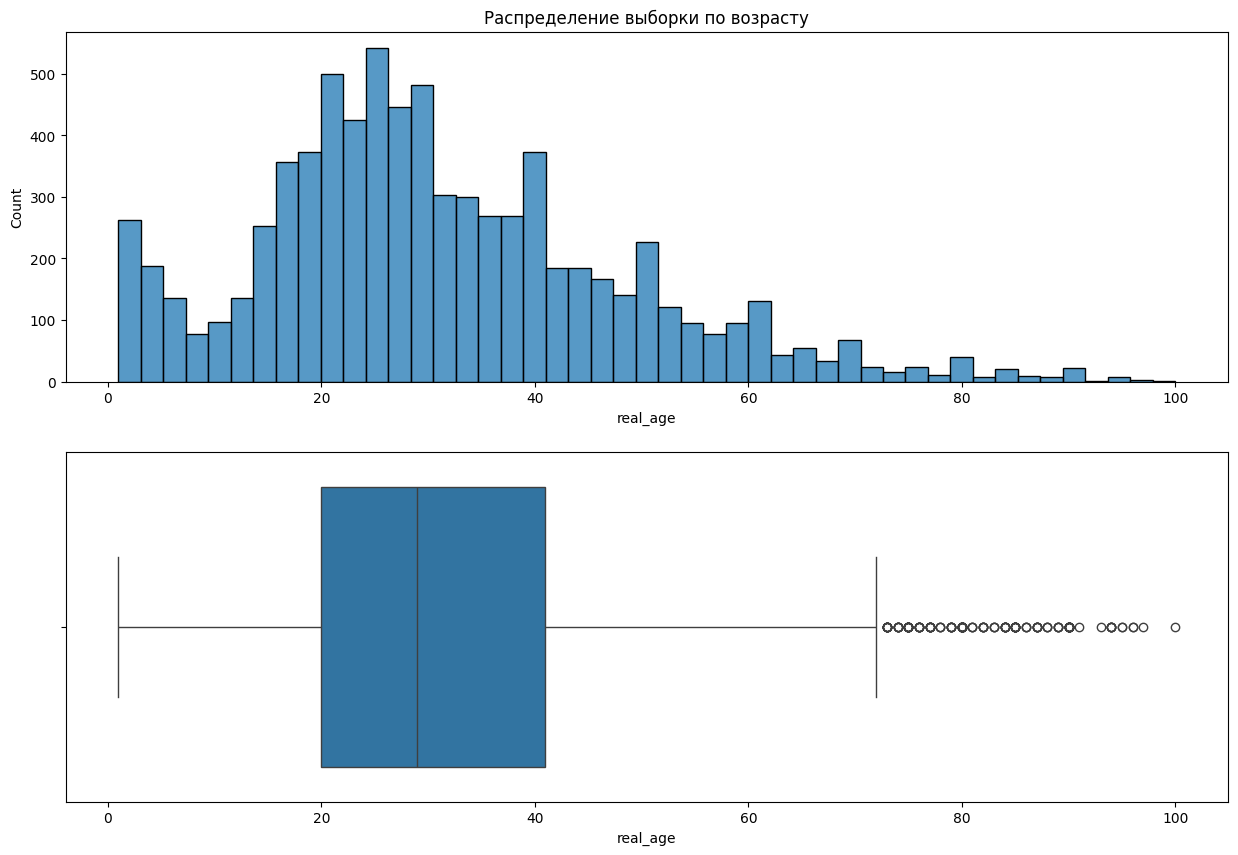

In [5]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 10)
sns.histplot(data=labels_df['real_age'], ax=ax[0]);
ax[0].set_title('Распределение выборки по возрасту')
sns.boxplot(data=labels_df['real_age'], orient='h', ax=ax[1]);
ax[1].set_yticklabels([]);

- Имеем ненормальное распределение с двумя модами
- При этом, если рассматривать распределение по аналагоии с классами, то возрасты представлены несбалансированно.

In [6]:
labels_df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

-  Значения от 1 до 100 лет, среднее примерно 31, медиана 29.
- Выбросов нет

In [7]:
f'{labels_df['real_age'].isna().sum()}'

'0'

- Пропусков нет

## Устройство датасета

In [8]:
dataflow = keras.preprocessing.image.ImageDataGenerator(validation_split=0.25).flow_from_dataframe(
    labels_df,
    DATA_PATH + '/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    class_mode='raw',
    subset='training',
    shuffle=True,
    batch_size=15,
    seed=RND_SEED
)

Found 5694 validated image filenames.


In [9]:
type(dataflow)

keras.src.legacy.preprocessing.image.DataFrameIterator

In [10]:
type(dataflow[0])

tuple

In [11]:
len(dataflow[0])

2

In [12]:
type(dataflow[0][0])

numpy.ndarray

In [13]:
type(dataflow[0][1])

numpy.ndarray

In [14]:
dataflow[0][0].shape

(15, 150, 150, 3)

In [15]:
dataflow[0][1].shape

(15,)

In [16]:
dataflow[0][1]

array([18, 12, 20, 16, 25, 46, 14, 34, 35, 40, 51, 33, 46, 38, 56])

- В каждой итерации DataFrameIterator возвращает tuple из двух массивов.
- В первом - батч из (в нашем случае) 15 картинок размером 150 на 150 и 3 каналами цвета
- Во втором - массив с (в нашем случае) 15 значениями возраста

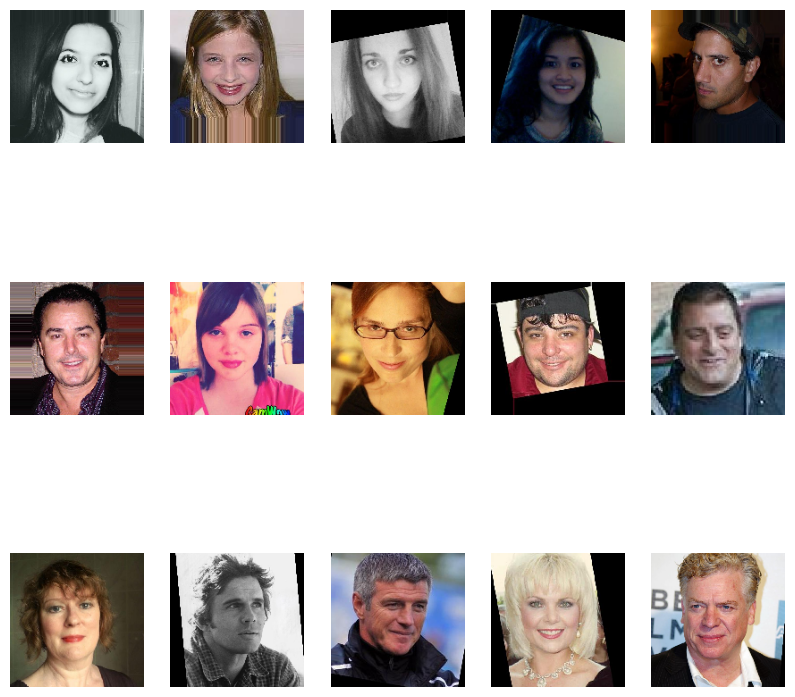

In [17]:
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(dataflow[0][0][i].astype('uint8'))
    plt.axis('off')
plt.show()

## Обучение модели (на локальной машине)

- Используем ResNet50 с готовыми весами *resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5*, без конечного слоя
- Включим ей дообучение
- В качестве конечного слоя добавим 3 полносвязных с активацией relu
- Сделаем картинки размером 150x150
- Аугментацию делать не будем (хотя, повороты на несколько градусов и небольшие смещения имели бы смысл, но точность почему-то падает, а времени на обучение больше)
- За функцию потерь возьмем *mean_squared_error*
- learning_rate сделаем 0.0001

In [18]:
def generator():
    return keras.preprocessing.image.ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255.,
#            horizontal_flip=True,
#            vertical_flip=True,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
#            rotation_range=5,
    )

def load_subset(path, subset):
    return generator().flow_from_dataframe(
        pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        subset=subset,
        batch_size=16,
        seed=42
)

def load_train(path):
	return load_subset(path, subset='training')

def load_test(path):
	return load_subset(path, subset='validation')

def create_model(input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'):
    backbone = keras.applications.resnet.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights=weights
    )
    backbone.trainable = True
    model = keras.models.Sequential()
    model.add(backbone)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

(При использовании ImageDataGenerator некоторые параметры fit(...) типа steps_per_epoch и validation_steps не используются, судя по спекам?)

Путь в load_... указан для локальной машины:

In [19]:
train_flow = load_train(DATA_PATH)
test_flow = load_test(DATA_PATH)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [20]:
features, target = train_flow[0]
print('input shape:', features[0].shape)
model = create_model(features[0].shape, WEIGHTS_PATH)
model = train_model(model,
	train_data=train_flow,
	test_data=test_flow)

input shape: (150, 150, 3)


2025-09-22 13:25:25.675117: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/home/wtom/code/notebooks/practicum/vision/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 - 768s - 2s/step - loss: 185.6547 - mae: 10.2484 - val_loss: 593.5673 - val_mae: 19.3491
Epoch 2/10
356/356 - 755s - 2s/step - loss: 76.7131 - mae: 6.7187 - val_loss: 272.7343 - val_mae: 12.3795
Epoch 3/10
356/356 - 756s - 2s/step - loss: 44.2060 - mae: 5.1197 - val_loss: 83.5207 - val_mae: 6.8727
Epoch 4/10
356/356 - 756s - 2s/step - loss: 31.5308 - mae: 4.2674 - val_loss: 77.9077 - val_mae: 6.6906
Epoch 5/10
356/356 - 753s - 2s/step - loss: 23.2267 - mae: 3.7146 - val_loss: 94.9218 - val_mae: 7.5931
Epoch 6/10
356/356 - 731s - 2s/step - loss: 20.5228 - mae: 3.4137 - val_loss: 77.1479 - val_mae: 6.7504
Epoch 7/10
356/356 - 721s - 2s/step - loss: 18.4052 - mae: 3.2523 - val_loss: 73.9810 - val_mae: 6.6258
Epoch 8/10
356/356 - 734s - 2s/step - loss: 15.8032 - mae: 3.0105 - val_loss: 76.7650 - val_mae: 6.5483
Epoch 9/10
356/356 - 737s - 2s/step - loss: 13.0838 - mae: 2.7614 - val_loss: 71.2785 - val_mae: 6.5034
Epoch 10/10
356/356 - 729s - 2s/step - loss: 12.8876 - mae: 2.7173 - 

## Анализ обученной модели
- Модель обучена, пороговое значение MAE на тестовой выборке достигнуто.
- Увеличение кол-ва эпох дает некторое увеличение точности, но может занять много времени. Начиная с какой-то эпохи, несмотря на увеличение точности на обучающей выборке, точность на валидационной может снижаться, видимо, из-за переобучения.

Посмотрим на распределение остатков по возрасту: получим предсказания на тестовой выборке и построим графики разброса ошибок по возрасту и распределения ошибок 

In [21]:
predictions = model.predict(test_flow, steps=len(test_flow))
predictions

119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step


array([[36.75273 ],
       [31.661882],
       [20.551863],
       ...,
       [55.786495],
       [32.52251 ],
       [44.63038 ]], shape=(1897, 1), dtype=float32)

In [22]:
predictions.shape

(1897, 1)

In [23]:
gen_1, gen_2 = tee(test_flow)

true_batch_list = []
pred_batch_list = []

for _ in range(len(test_flow)):
	true_batch_list.append(next(gen_1)[1])
	pred_batch_list.append(np.hstack(model.predict(next(gen_2), steps=1)))

/home/wtom/code/notebooks/practicum/vision/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_175
Received: inputs=('Tensor(shape=(16, 150, 150, 3))', 'Tensor(shape=(16,))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/wtom/code/notebooks/practicum/vision/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_175
Received: inputs=('Tensor(shape=(None, 150, 150, 3))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [24]:
true_ages = np.concatenate(true_batch_list)
pred_ages = np.concatenate(pred_batch_list)
print('true:', true_ages.shape)
print('pred:', pred_ages.shape)
residuals = pred_ages - true_ages


true: (1897,)
pred: (1897,)


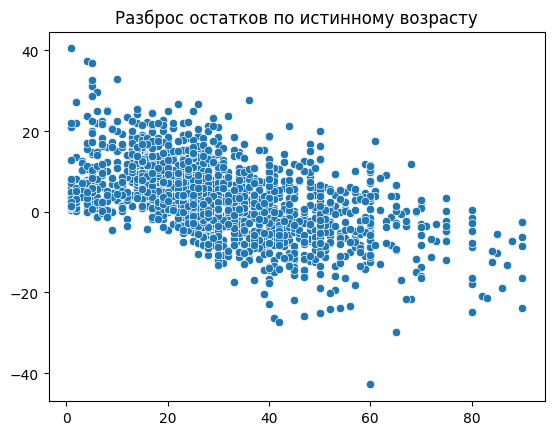

In [25]:
sns.scatterplot(x=true_ages, y=residuals).set_title('Разброс остатков по истинному возрасту');

- Есть небольшой наклон в сторону отицательных остатков с увеличением возраста. Но в целом разброс выглядит довольно равномерно.

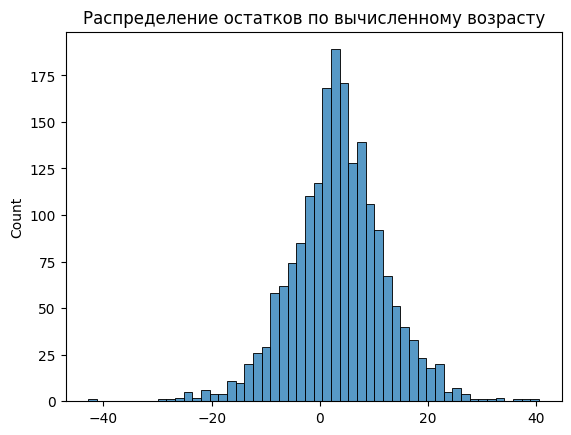

In [26]:
sns.histplot(x=residuals).set_title('Распределение остатков по вычисленному возрасту');

- Почти нормальное распределение с модой, близкой к нулю. Нормальное распределение говорит в пользу качества обученной модели

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы